## Preparation

- [ ] gradient correctly established in new plate praparation?
- [ ] energy supply reasonable?
- [ ] initial kill and replication rates ok? What are reasonable limits?
- [ ] How many steps for 2k generations to expect?
- [ ] Is mutation rate development reasonable?

In [1]:
import math
import pandas as pd
import torch
from plotnine import *
import magicsoup as ms
from magicsoup.constants import GAS_CONSTANT
from e1_co2_fixing.chemistry import MOLECULES, CHEMISTRY, GENOMES, get_proteome_fact
from e1_co2_fixing.util import sigm, sigm_sample, rev_sigm, rev_sigm_sample
from e1_co2_fixing.experiment import MapCenterSquareGradient

theme_set(theme_minimal())

### Genome Sizes

- 7 common reactions, max pathway 13 reactions, so expect 20 proteins for healthy proteome
- I need at least size 600 to generate initial genomes for every pathway
- randomly genomes of size 1000 would have ~20 proteins
- random genome size >1400 has ~30 proteins, which seems excessive => should be penalized

In [26]:
size = 600
for genome_name in GENOMES:
    world = ms.World(chemistry=CHEMISTRY)
    proteome_fact = get_proteome_fact(proteome_name=genome_name)
    world.generate_genome(proteome=proteome_fact, size=size)

In [29]:
def proteome_stats(proteome: list[list], records: list[dict], size: int, record: dict):
    records.append({
        **record,
        "n": len(proteome),
        "v": "proteins/genome"
    })
    if len(proteome) > 0:
        n_doms = sum(len(d) for d in proteome)
        records.append({
            **record,
            "n": n_doms / len(proteome),
            "v": "domains/protein"
        })
        records.append({
            **record,
            "n": n_doms * genetics.dom_size / size,
            "v": "coding nts/nt"
        })

genetics = ms.Genetics()

records = []
for size in (600, 1000, 1400):
    genomes = [ms.random_genome(s=size) for _ in range(1000)]
    proteomes = genetics.translate_genomes(genomes=genomes)
    for proteins in proteomes:
        proteome_stats(proteome=proteins, records=records, size=size, record={"size": size})

df = pd.DataFrame.from_records(records)
avgs = df.groupby(["v", "size"])["n"].mean().reset_index()

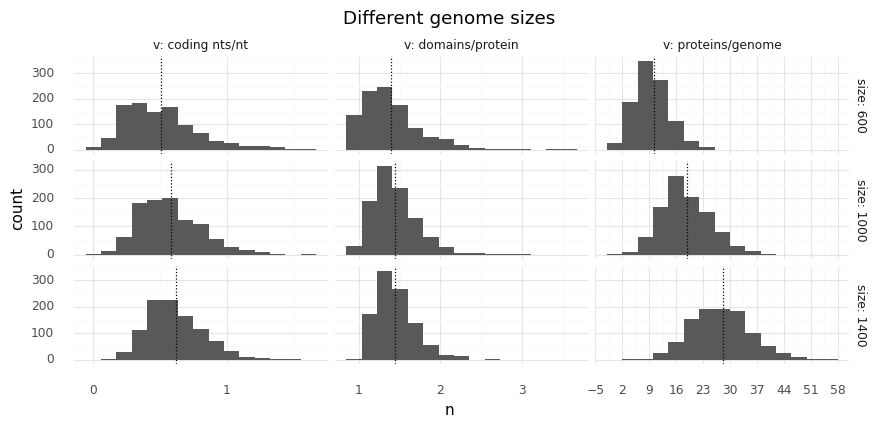

<ggplot: (8770125158734)>

In [32]:
def get_breaks(l: list[float]) -> list[float]:
    lower = math.floor(min(l))
    upper = math.ceil(max(l))
    return range(lower, upper, math.ceil((upper - lower) / 10))

(ggplot()
    + geom_histogram(aes(x="n"), data=df, bins=15)
    + geom_vline(aes(xintercept="n"), data=avgs, linetype="dotted")
    + facet_grid("size ~ v", scales="free", labeller="label_both")
    + scale_x_continuous(breaks=get_breaks)
    + theme(figure_size=(10, 4))
    + ggtitle("Different genome sizes"))

### Mutation Rates

- for point mutations 1e-6 to 1e-4 seems ok, 1e-3 is a bit much (120% mutated after just 100s)
- for recombinations even 1e-4 is a bit excessive, 1e-5 to 1e-7 looks good

In [72]:
n = 100
sizes = [600, 1000, 1400]
ps = [1e-4, 1e-5, 1e-6]

records = []
for size in sizes:
    for p in ps:
        genomes = [ms.random_genome(s=size) for _ in range(n)]
        state = {i: 0 for i in range(n)}
        for step_10s in range(1000):
            records.extend([
                {"i": i, "t": step_10s, "n": d, "size": size, "p": p}
                for i, d in state.items()
            ])
            mutations = ms.point_mutations(seqs=genomes, p=p)
            for _, i in mutations:
                state[i] += 1

df = pd.DataFrame.from_records(records)

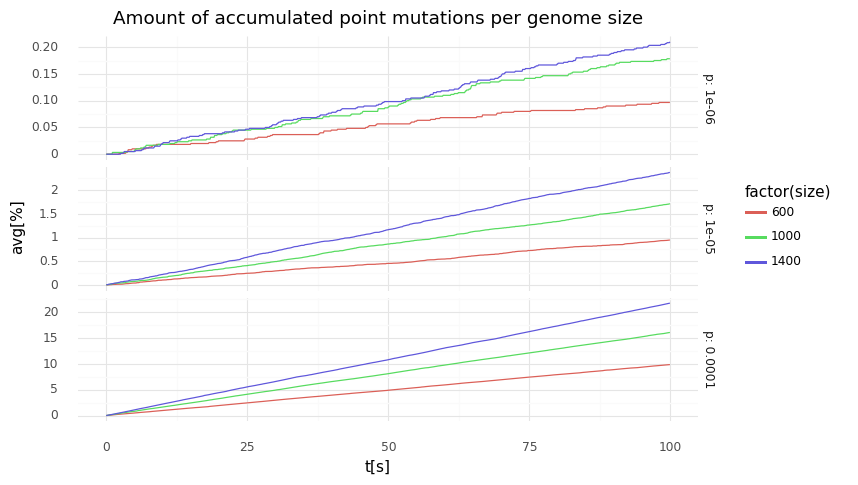

<ggplot: (8770032435630)>

In [73]:
df1 = df.groupby(["t", "size", "p"])["n"].mean().reset_index()
df1["t[s]"] = df1["t"] / 10
df1["avg[%]"] = df1["n"] / df["size"] * 100

(ggplot(df1)
    + geom_line(aes(x="t[s]", y="avg[%]", color="factor(size)"))
    + facet_grid("p ~ .", scales="free", labeller="label_both")
    + theme(figure_size=(8, 5))
    + ggtitle("Amount of accumulated point mutations per genome size"))

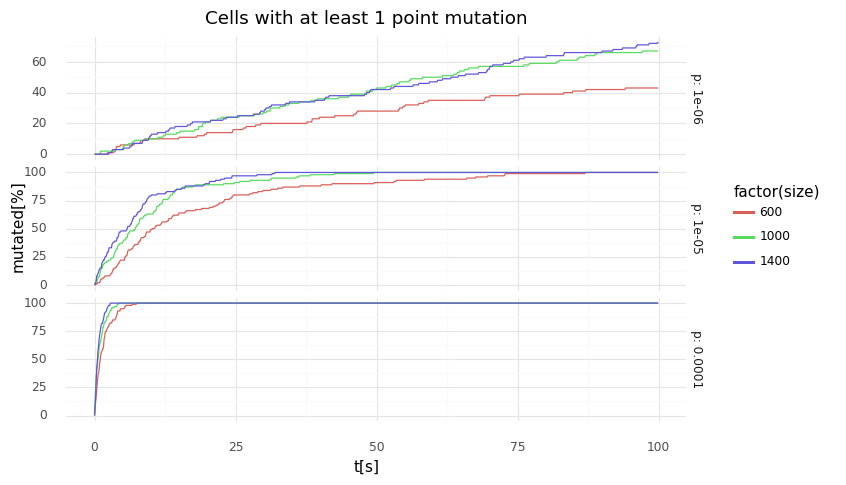

<ggplot: (8770122210968)>

In [74]:
df1 = df.groupby(["t", "size", "p"])["n"].agg(lambda d: sum(d > 0) / len(d)).reset_index()
df1["t[s]"] = df1["t"] / 10
df1["mutated[%]"] = df1["n"] * 100

(ggplot(df1)
    + geom_line(aes(x="t[s]", y="mutated[%]", color="factor(size)"))
    + facet_grid("p ~ .", scales="free", labeller="label_both")
    + theme(figure_size=(8, 5))
    + ggtitle("Genomes with at least 1 point mutation"))

In [10]:
n = 100
sizes = [600, 1000, 1400]
ps = [1e-5, 1e-6, 1e-7]

records = []
for size in sizes:
    for p in ps:
        genomes = [ms.random_genome(s=size) for _ in range(n)]
        state = {i: 0 for i in range(n)}
        for step_10s in range(1000):
            records.extend([
                {"i": i, "t": step_10s, "n": d, "size": size, "p": p}
                for i, d in state.items()
            ])
            mutations = ms.recombinations(seq_pairs=[(d, d) for d in genomes], p=p)
            for _0, _1, i in mutations:
                state[i] += 1

df = pd.DataFrame.from_records(records)

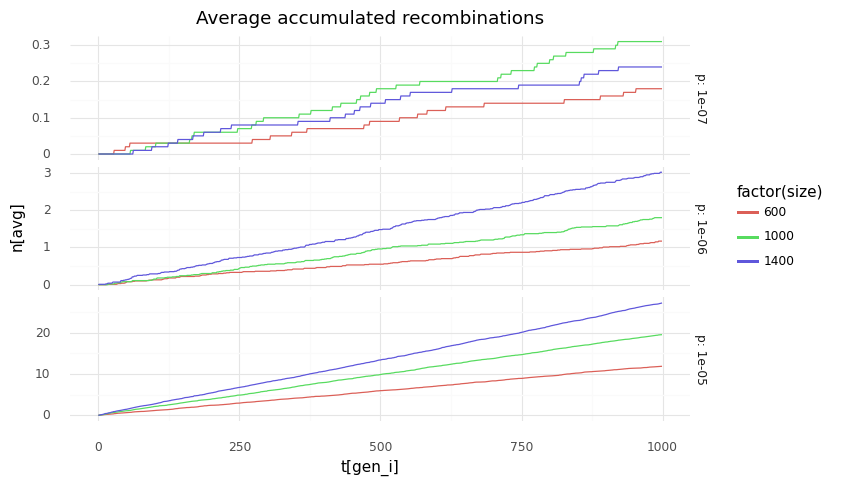

<ggplot: (8749911802604)>

In [11]:
df1 = df.groupby(["t", "size", "p"])["n"].mean().reset_index()
df1["t[gen_i]"] = df1["t"]
df1["n[avg]"] = df1["n"]

(ggplot(df1)
    + geom_line(aes(x="t[gen_i]", y="n[avg]", color="factor(size)"))
    + facet_grid("p ~ .", scales="free", labeller="label_both")
    + theme(figure_size=(8, 5))
    + ggtitle("Average accumulated recombinations"))

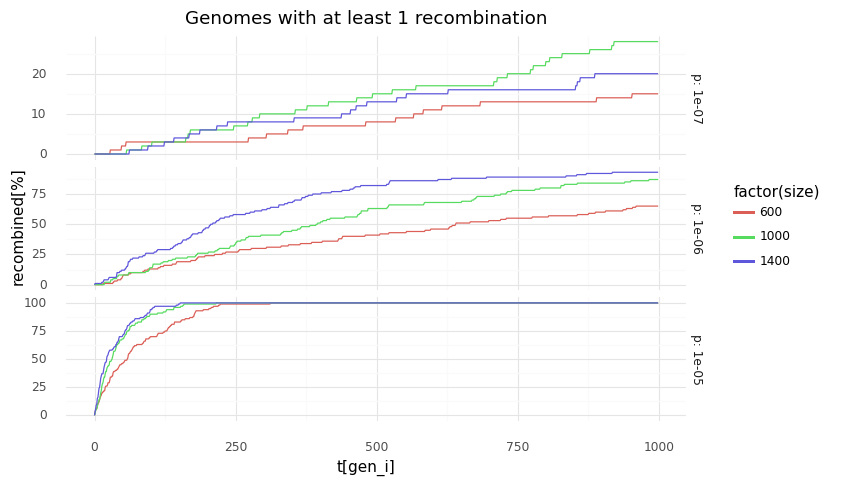

<ggplot: (8749911611720)>

In [12]:
df1 = df.groupby(["t", "size", "p"])["n"].agg(lambda d: sum(d > 0) / len(d)).reset_index()
df1["t[gen_i]"] = df1["t"]
df1["recombined[%]"] = df1["n"] * 100

(ggplot(df1)
    + geom_line(aes(x="t[gen_i]", y="recombined[%]", color="factor(size)"))
    + facet_grid("p ~ .", scales="free", labeller="label_both")
    + theme(figure_size=(8, 5))
    + ggtitle("Genomes with at least 1 recombination"))

### CO2 Gradient

- adding CO2 with diffusion 100 times seems ok for setting up the gradient
- gradients >0.5 are kind of useless (half the map is 100.0 CO2)

In [22]:
MOL_2_I = {d.name: i for i, d in enumerate(MOLECULES)}
CO2_I = MOL_2_I["CO2"]

gradient_size = 0.2
n = 41
step = 10

records = []
for map_size in [128, 256]:
    world = ms.World(chemistry=CHEMISTRY, map_size=map_size, mol_map_init="zeros")
    add_co2 = MapCenterSquareGradient(ratio=gradient_size, map_size=world.map_size)
    
    for _ in range(100):
        add_co2(world.molecule_map[CO2_I])
        world.diffuse_molecules()

    ticks = list(range(world.map_size))
    xs = ticks * world.map_size
    ys = [d for d in ticks for _ in range(world.map_size)]

    def record_map(molmap: torch.Tensor, t: int):
        mols = molmap.flatten().tolist()
        for x, y, c in zip(xs, ys, mols):
            records.append({"t": t, "x": x, "y": y, "n[CO2]": c, "size": str(map_size)})
    
    record_map(world.molecule_map[CO2_I], 0)
    for s in range(n):
        if s % step == 0:
            record_map(world.molecule_map[CO2_I], s)
        
        add_co2(world.molecule_map[CO2_I])
        world.diffuse_molecules()

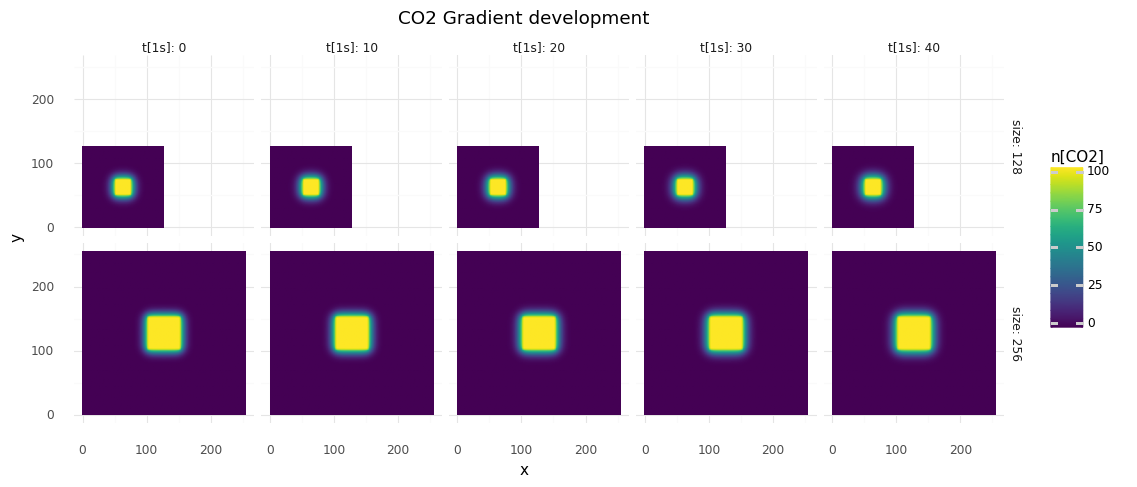

<ggplot: (8749909266426)>

In [23]:
df = pd.DataFrame.from_records(records)
df["t[1s]"] = df["t"]

(ggplot(df)
    + geom_raster(aes(x="x", y="y", fill="n[CO2]"))
    + facet_grid("size ~ t[1s]", labeller="label_both")
    + coord_equal(expand=True)
    + theme(figure_size=(12, 6))
    + ggtitle("CO2 Gradient development"))

In [24]:
gradient_sizes = [0.2, 0.4, 0.6]
map_size = 256

records = []
for map_size in [128, 256]:
    ticks = list(range(map_size))
    xs = ticks * map_size
    ys = [d for d in ticks for _ in range(map_size)]

    def record_map(molmap: torch.Tensor, g: float):
        mols = molmap.flatten().tolist()
        for x, y, c in zip(xs, ys, mols):
            records.append(
                {"x": x, "y": y, "n[CO2]": c, "map_size": str(map_size), "gradient_size": f"{g:.1f}"}
            )

    for gradient_size in gradient_sizes:
        world = ms.World(chemistry=CHEMISTRY, map_size=map_size, mol_map_init="zeros")
        add_co2 = MapCenterSquareGradient(ratio=gradient_size, map_size=world.map_size)
    
        for _ in range(200):
            add_co2(world.molecule_map[CO2_I])
            world.diffuse_molecules()
    
        record_map(world.molecule_map[CO2_I], gradient_size)

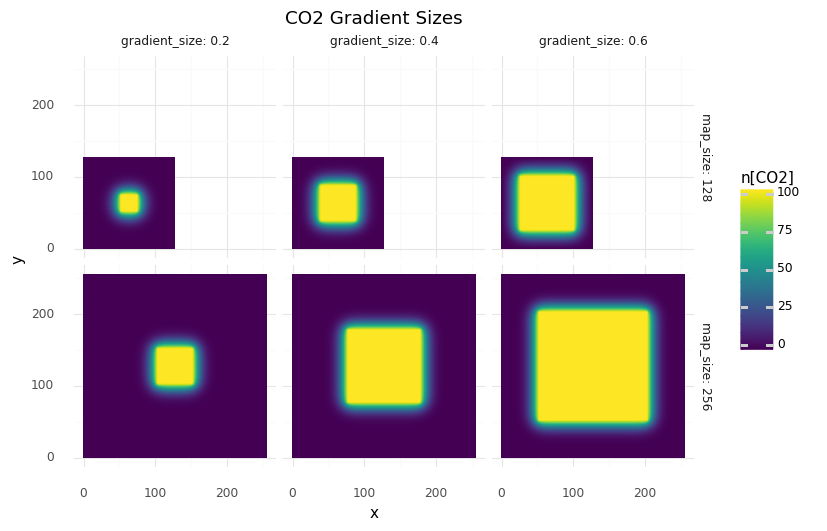

<ggplot: (8749911918692)>

In [26]:
df = pd.DataFrame.from_records(records)

(ggplot(df)
    + geom_raster(aes(x="x", y="y", fill="n[CO2]"))
    + facet_grid("map_size ~ gradient_size", labeller="label_both")
    + coord_equal(expand=True)
    + theme(figure_size=(8, 4))
    + ggtitle("CO2 Gradient Sizes"))

### Equilibrium constants

- $K_e$ near 0 have a chance of moving in both directions
- $|log_{10}(K_e)| > 3$ is basically irreversible (e.g. highest levels are probably CO2 with 100.0: would need 0.1 product concentration to move against $|log_{10}(K_e)| = 3$)
- want to see if my chemistry even allows for that

In [27]:
world = ms.World(chemistry=CHEMISTRY)
genomes = [ms.random_genome(s=1000) for _ in range(100)]
world.add_cells(genomes=genomes)
lKe = world.kinetics.E / world.abs_temp / GAS_CONSTANT / 2.303

records = []
for lke in lKe[lKe != 0.0].flatten().tolist():
    records.append({"lKe": lke})

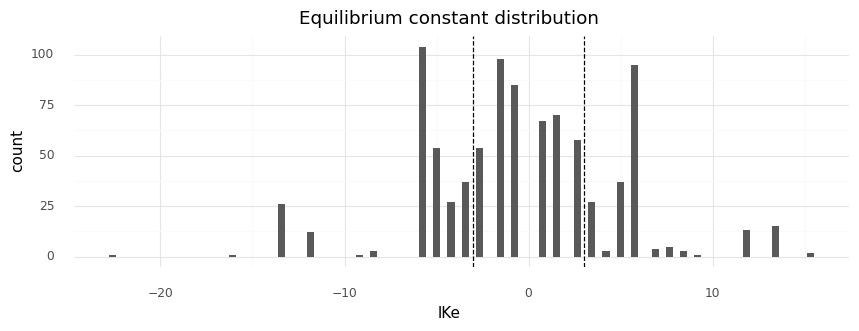

<ggplot: (8749911754230)>

In [30]:
df = pd.DataFrame.from_records(records)
df1 = pd.DataFrame({"lKe": [-3, 3]})

(ggplot()
    + geom_histogram(aes(x="lKe"), data=df, bins=100)
    + geom_vline(aes(xintercept="lKe"), data=df1, linetype="dashed")
    + theme(figure_size=(10, 3))
    + ggtitle("Equilibrium constant distribution"))

### Replication and Killing

- killing depends on $X$ concentration and genome size, replication depends on $X$
- $X$-dependent functions are pretty much fine-tuning
- but I could see what ranges are useful given realist molecule concentrations
- genome sizes > 1000 should get penalized, sizes > 1500 should basically be instant death
- killed by genome size: n=7, 2000 <= k <= 2500
- killed by low X: n=3, 0.2 <= k <= 0.4
- replicated by high X: n=3, 15 <= k <= 30

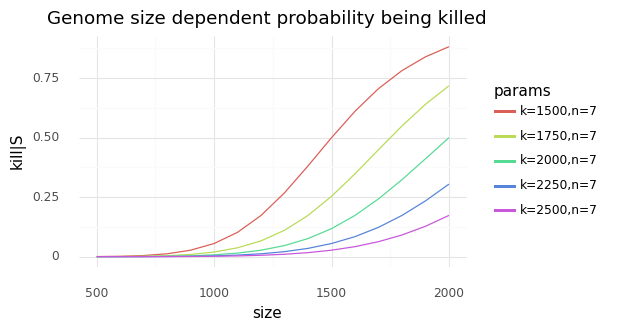

<ggplot: (8743477692392)>

In [50]:
paramsets = [
    (1500.0, 7),
    (1750.0, 7),
    (2000.0, 7),
    (2250.0, 7),
    (2500.0, 7),
]
S = torch.arange(500.0, 2001.0, 100.0)

dicts = []
for k, n in paramsets:
    name = f"k={k:.0f},n={n}"
    dicts.append({"size": S.tolist(), "kill|S": sigm(S, k=k, n=n), "params": name})
df = pd.concat([pd.DataFrame(d) for d in dicts], ignore_index=True)

(ggplot(df)
    + geom_line(aes(x="size", y="kill|S", color="params"))
    + theme(figure_size=(5, 3))
    + ggtitle("Genome size dependent probability being killed"))

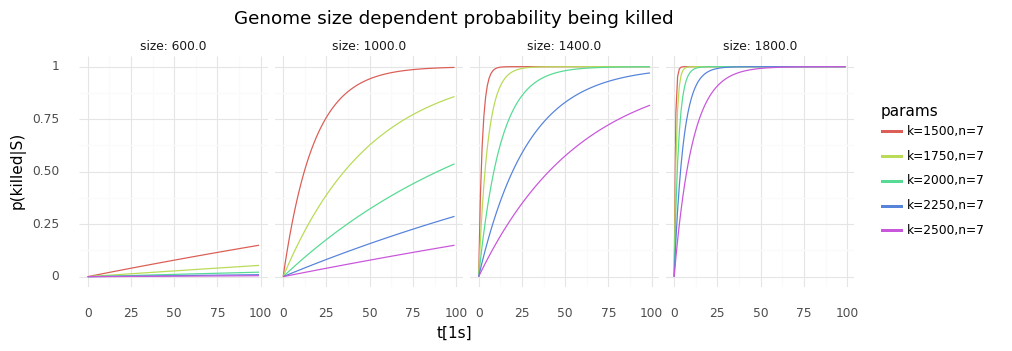

<ggplot: (8743477692389)>

In [51]:
n_steps = 100
sizes = [600.0, 1000.0, 1400.0, 1800.0]

records = []
for k, n in paramsets:
    for size in sizes:
        for t in range(n_steps):
            name = f"k={k:.0f},n={n}"
            p = sigm(torch.tensor(size), k=k, n=n).item()
            records.append({
                "t[1s]": t,
                "size": size,
                "p(killed|S)": (1 - (1 - p) ** t),
                "params": name,
            })
df = pd.DataFrame.from_records(records)

(ggplot(df)
    + geom_line(aes(x="t[1s]", y="p(killed|S)", color="params"))
    + facet_grid("~ size", labeller="label_both", scales="free_x")
    + theme(figure_size=(10, 3))
    + ggtitle("Genome size dependent probability being killed"))

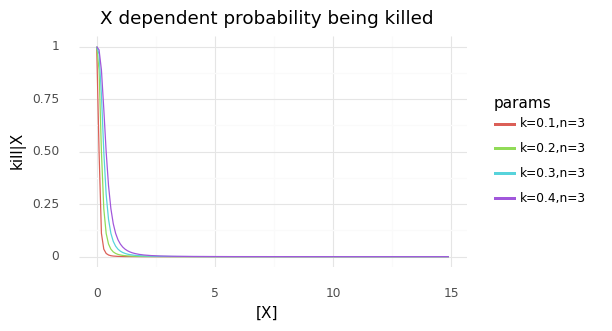

<ggplot: (8743477582494)>

In [64]:
paramsets = [
    (0.1, 3),
    (0.2, 3),
    (0.3, 3),
    (0.4, 3),
]
X = torch.arange(0.0, 15.0, 0.1)

dicts = []
for k, n in paramsets:
    name = f"k={k:.1f},n={n}"
    dicts.append({"[X]": X.tolist(), "kill|X": rev_sigm(X, k=k, n=n), "params": name})
df = pd.concat([pd.DataFrame(d) for d in dicts], ignore_index=True)

(ggplot(df)
    + geom_line(aes(x="[X]", y="kill|X", color="params"))
    + theme(figure_size=(5, 3))
    + ggtitle("X dependent probability being killed"))

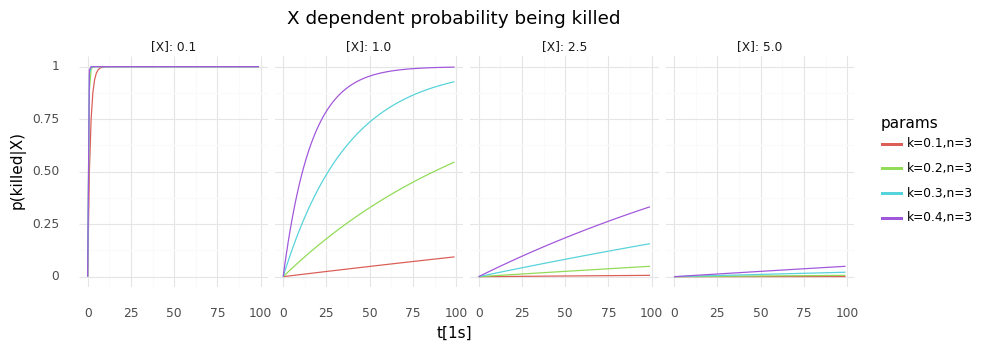

<ggplot: (8743478043633)>

In [65]:
n_steps = 100
amounts = [0.1, 1.0, 2.5, 5.0]

records = []
for k, n in paramsets:
    for amount in amounts:
        for t in range(n_steps):
            name = f"k={k:.1f},n={n}"
            p = rev_sigm(torch.tensor(amount), k=k, n=n).item()
            records.append({
                "t[1s]": t,
                "[X]": amount,
                "p(killed|X)": (1 - (1 - p) ** t),
                "params": name,
            })
df = pd.DataFrame.from_records(records)

(ggplot(df)
    + geom_line(aes(x="t[1s]", y="p(killed|X)", color="params"))
    + facet_grid("~ [X]", labeller="label_both", scales="free_x")
    + theme(figure_size=(10, 3))
    + ggtitle("X dependent probability being killed"))

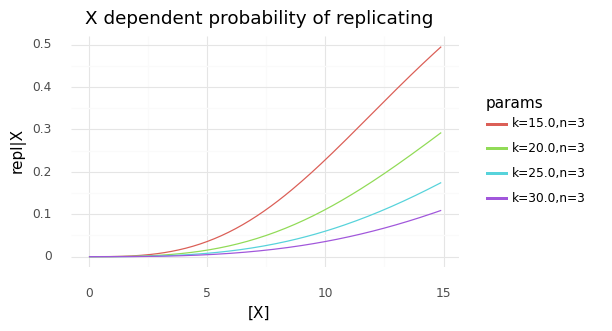

<ggplot: (8743479003106)>

In [77]:
paramsets = [
    (15.0, 3),
    (20.0, 3),
    (25.0, 3),
    (30.0, 3),
]
X = torch.arange(0.0, 15.0, 0.1)

dicts = []
for k, n in paramsets:
    name = f"k={k:.1f},n={n}"
    dicts.append({"[X]": X.tolist(), "repl|X": sigm(X, k=k, n=n), "params": name})
df = pd.concat([pd.DataFrame(d) for d in dicts], ignore_index=True)

(ggplot(df)
    + geom_line(aes(x="[X]", y="repl|X", color="params"))
    + theme(figure_size=(5, 3))
    + ggtitle("X dependent probability of replicating"))

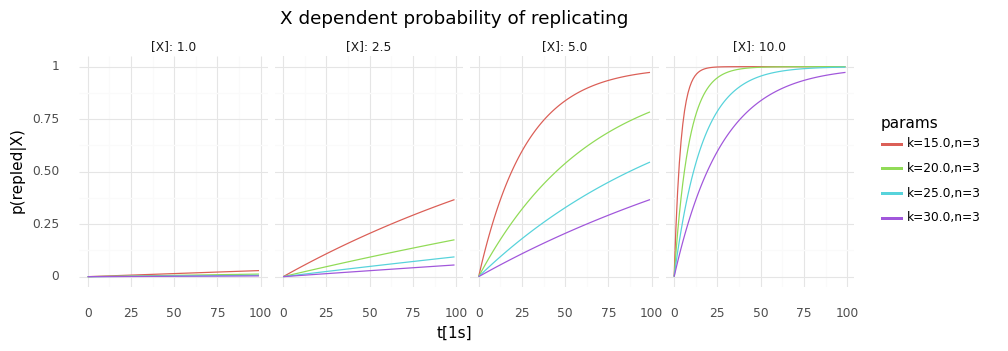

<ggplot: (8743476882348)>

In [78]:
n_steps = 100
amounts = [1.0, 2.5, 5.0, 10.0]

records = []
for k, n in paramsets:
    for amount in amounts:
        for t in range(n_steps):
            name = f"k={k:.1f},n={n}"
            p = sigm(torch.tensor(amount), k=k, n=n).item()
            records.append({
                "t[1s]": t,
                "[X]": amount,
                "p(repled|X)": (1 - (1 - p) ** t),
                "params": name,
            })
df = pd.DataFrame.from_records(records)

(ggplot(df)
    + geom_line(aes(x="t[1s]", y="p(repled|X)", color="params"))
    + facet_grid("~ [X]", labeller="label_both", scales="free_x")
    + theme(figure_size=(10, 3))
    + ggtitle("X dependent probability of replicating"))